# Recognition Parametrized Gaussian Process Factror Analysis (RP-GPFA): Multimodal Time series

Observations $\mathcal{X} = \{ x_{jt}, j=1:2, t=1:T \}$:
- $j=1$: Videos of moving ellipsoid in a room. 
- $j=2$: Audio Snippets emitted from one of the ellipsoid and recorded from the 4 corner of the room.

The conditional independence relationship factorises across time ($t$) and modalities ($j$):

$$ \mathsf{P_{\theta}}(\mathcal{X}, \mathcal{Z}) = \mathsf{p_{\theta_z}}(\mathcal{Z}) \prod_{j,t} \left( \mathsf{p_{0,jt}}(\mathsf{x_{jt}}) \frac{\mathsf{f_{\theta j}}(\mathsf{z_{t}} | \mathsf{x_{jt}})}{\mathsf{F_{\theta j}}(\mathsf{z}_{t})} \right) $$


 <div align="center">
     <img src="figures/rpgpfa.png" width="1000"/>
 </div>
 
 
 

In [4]:
import torch
import numpy as np
from torch import matmul
import matplotlib.pyplot as plt

from utils_demo import generate_lorenz
from kernels import RBFKernel

import torch
import numpy as np
from torch import matmul
import matplotlib.pyplot as plt
from kernels import RBFKernel
import torch.nn.functional as F
from mpl_toolkits.mplot3d import Axes3D
import imageio
import imageio
import pickle
# %%


# GPUs ?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data type: float64 / float32
data_type = torch.float32
torch.set_default_dtype(data_type)

# Stored Videos
# trajectory_folder = '../videos_rpm/'
# trajectory_name = 'trajectories_param.pkl'

trajectory_folder = '/nfs/ghome/live/hugos/Documents/PYTHON/videos_rpm/'
trajectory_name = 'trajectories_param.pkl'


##%%

# Load Trajectories
with open(trajectory_folder + trajectory_name, "rb") as input_file:
        trajectories = pickle.load(input_file)


# ~ N x Agent x T x 2
spatial_trajectories = trajectories['spatial_trajectories']

# ~ N x T x 4
distance_from_fixed = trajectories['distance_from_fixed']

# Id.
main_agent = trajectories['main_agent']

# N x T x W x H
video_tensor = trajectories['video_tensor']
num_observations_full, len_observation, width, height = video_tensor.shape

# ~ N x T x 2
main_trajectory = spatial_trajectories[:, main_agent]






In [5]:

##%% Plots

# Plot videos and sound recordings for one observation (if not on GPU)
plot_observations = not(torch.cuda.is_available())

if plot_observations:

    # Microphone Locations
    mic_position = torch.tensor([[-1, -1], [-1, +1], [+1, -1], [+1, +1]], device=device, dtype=data_type)
    mic_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    # 'Color' of the agents
    c1 = [0.8, 0.8, 0.8]
    c2 = [0.5, 0.5, 0.5]
    c3 = [0.3, 0.3, 0.3]
    color_agents = [c1, c2, c3]

    obs_eg = 6
    tplot = [0, 100, 150]

    pheigh = int(np.floor(np.sqrt(len(tplot)+2)))
    pwidth = int(np.ceil((len(tplot)+2) / pheigh))

    pheigh = 1
    pwidth = int(np.ceil((len(tplot) + 2) / pheigh))

    plt.figure(figsize=(pwidth * 4, pheigh * 4))

    for tt_id in range(len(tplot)):
        name = 'video_' + 'full_plot_n' + str(obs_eg).zfill(3) + '_t' + str(tplot[tt_id]).zfill(4) + '.png'
        im = imageio.imread(trajectory_folder + name)
        print(name)
        plt.subplot(pheigh, pwidth, tt_id + 1)
        plt.imshow(im)
        plt.imshow(video_tensor[obs_eg, tplot[tt_id]], cmap='gray')

        plt.title('t = ' + str(tplot[tt_id]) + '/' + str(len_observation))
        plt.xlim([75, 550])
        plt.ylim([550, 75])
        plt.axis('off')

    plt.subplot(pheigh, pwidth, tt_id + 2)
    for ii in range(mic_position.shape[0]):
        plt.scatter(mic_position[ii, 0], mic_position[ii, 1], s=100, c=mic_colors[ii], marker='s')
    plt.plot(main_trajectory[obs_eg, :, 0], main_trajectory[obs_eg, :, 1], c=color_agents[main_agent])
    plt.scatter(main_trajectory[obs_eg, 0, 0], main_trajectory[obs_eg, 0, 1], s=100, c=color_agents[main_agent],
                label='Start')
    plt.title('Top View')
    plt.xticks([-1, 0, 1])
    plt.yticks([-1, 0, 1])
    plt.xlabel('z1[t]')
    plt.ylabel('z2[t]')
    plt.legend()

    plt.subplot(pheigh, pwidth, tt_id + 3)
    for ii in range(mic_position.shape[0]):
        plt.plot(np.linspace(0, 1, len_observation), distance_from_fixed[obs_eg, :, ii], c=mic_colors[ii],
                    label='mic.' + str(ii))
    plt.legend(loc=5)
    plt.title('Distance(mic.)')
    plt.xlabel('Time [a.u]')


##%%



In [35]:
##%% Fit
num_observation = 50
# Build Observed Factors (Transfer to GPU if necessary)
observations1 = torch.tensor(
    video_tensor[:num_observation, :, 1:][..., 1:-2],
    device=device,
    dtype=data_type
)
observations1 = (1 - observations1 / observations1.max())
observations2 = torch.tensor(distance_from_fixed[:num_observation], device=device, dtype=data_type)


/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [36]:
def get_speech_samples(distance_from_fixed, audio_path, downsample=10, len_snippet=1000, normalize=True):

    num_observations, len_observation, _ = distance_from_fixed.shape
    data_type = distance_from_fixed.dtype
    device = distance_from_fixed.device

    speech_snips = np.zeros((num_observations, len_observation, len_snippet))

    cur_obs = 0
    cur_time = 0

    # Grasp all audio files
    for path in Path(audio_path).rglob('*.wav'):

        # Grasp data
        data, samplerate = sf.read(path)

        # Downsample data
        data = data[::downsample]

        # Get the length (in second) of each audio snippet
        samplerate = samplerate / downsample
        time_snippet_sec = len_snippet / samplerate


        # Number of snippet in the current data file
        snippet_num_cur = int(np.floor(len(data)/len_snippet))

        for inds in range(snippet_num_cur):

            # Break if filled all observations with sound snippet
            if cur_obs >= num_observations:
                break

            # Fill Current observation and current time with sound snippet
            speech_snips[cur_obs, cur_time] = data[len_snippet * inds:len_snippet * (inds + 1)]

            # Update Time
            cur_time += 1

            # If all time point have been filled, move to next observation
            if cur_time >= len_observation:
                cur_obs += 1
                cur_time = 0

    # Error if you didn't fill the array
    if cur_obs < num_observations:
        raise Exception('Not enough speech snippets in timit')

    # Get speech samples
    speech_data = torch.tensor(speech_snips, dtype=data_type, device=device)
    if normalize:
        speech_data = speech_data - speech_data.mean(dim=-1, keepdim=True)
        speech_data = speech_data / speech_data.max(dim=-1)[0].unsqueeze(-1)

    # Maximum distance in the square arena
    dmax = torch.sqrt(torch.tensor([8]))

    # Enveloppe signal
    modulation = (dmax - distance_from_fixed) / dmax

    # Modulate
    distance_modulated_speech = (modulation.unsqueeze(-1) * speech_data.unsqueeze(-2))

    return distance_modulated_speech, time_snippet_sec

In [37]:
from pathlib import Path
import soundfile as sf
len_snippet = 100
audio_path = '/nfs/ghome/live/hugos/Documents/PYTHON/timit/train/'
distance_modulated_audio, time_snippet_sec = get_speech_samples(
    distance_from_fixed, 
    audio_path,
    downsample=20,
    len_snippet=len_snippet,
    normalize=True
)


In [38]:
use_sound_speech = True
if use_sound_speech:
    tmp = distance_modulated_audio[:num_observation] #.reshape(num_observation, len_observation, -1)
    tmp = (tmp**2).mean(dim=-1)
    observations2 = torch.tensor(tmp, device=device, dtype=data_type)


/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [39]:
observations2.shape 

torch.Size([50, 200, 4])

In [40]:
def normalize_observations(obs, num_event_dim=1):

    full_dim = obs.shape
    batch_dim = torch.tensor(obs.shape[:num_event_dim])
    event_dim = torch.tensor(obs.shape[num_event_dim:])

    obs = obs.reshape(batch_dim.prod(), event_dim.prod())
    o_mean, o_std = torch.mean(obs, dim=0, keepdim=True), torch.std(obs, dim=0, keepdim=True)
    obs = (obs - o_mean) / (o_std + 1e-6)
    obs = obs.reshape(full_dim)

    return obs

observations1 = normalize_observations(observations1, num_event_dim=2)
observations2 = normalize_observations(observations2, num_event_dim=2)

observations = [observations1, observations2]

len_snippet = 100
dim_latent = 2
num_inducing = 50

observation_locations = torch.linspace(0, 1, len_observation, device=device, dtype=data_type).unsqueeze(-1)
inducing_locations = observation_locations[np.floor(np.linspace(0, len_observation-1, num_inducing).astype(int))]


Text(0.5, 0, 'Epoch')

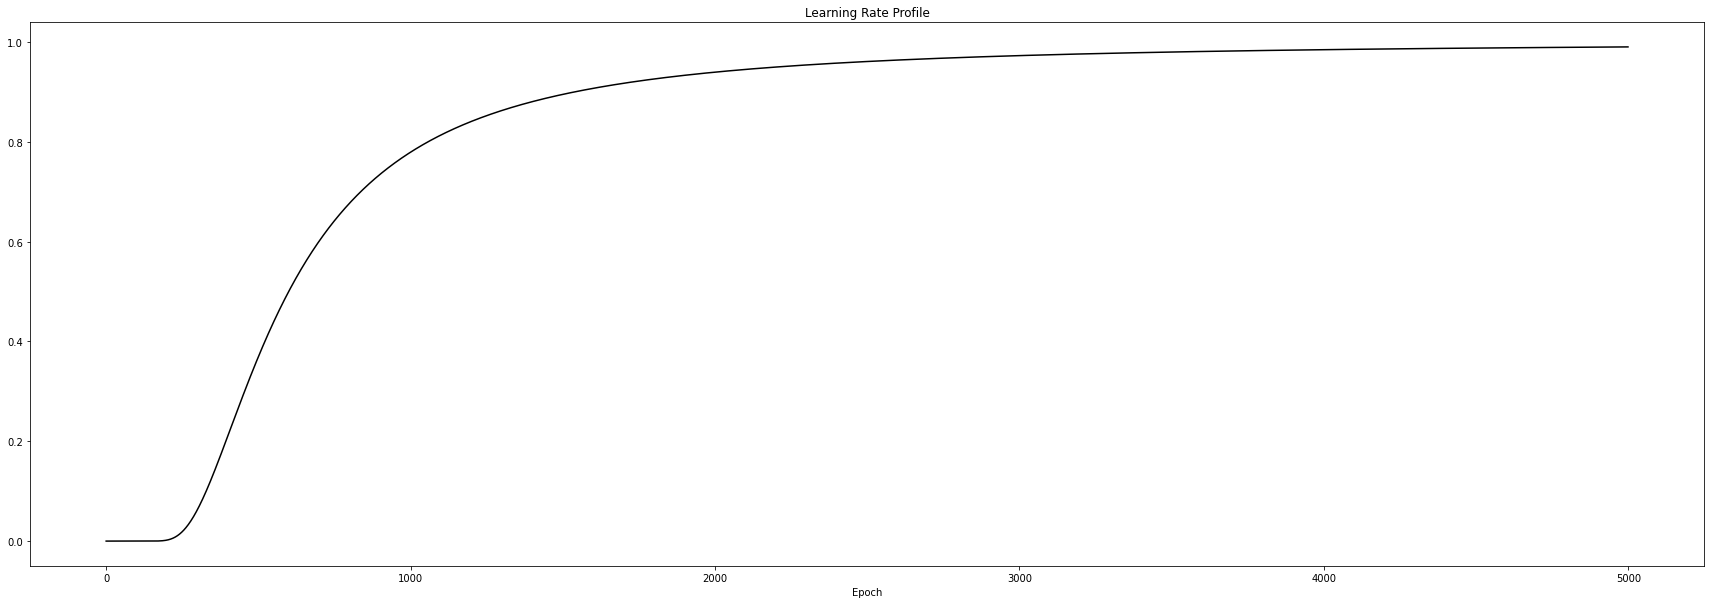

In [41]:
num_epoch = 5000
alpha =  10 / num_epoch
lr_sigmoid = lambda xx: np.exp(- 1 / ((xx + 1) * alpha) ** 2)

xx = np.arange(num_epoch)
yy = lr_sigmoid(xx)

plt.figure(figsize=(30, 10))
plt.plot(xx, yy, c='k')
plt.title('Learning Rate Profile')
plt.xlabel('Epoch')
#plt.xlim([0, 300])


In [42]:

from recognition_parametrised_model import RPM
import torch.nn.functional as F

prior_params = {
    'gp_kernel': 'RBF',
    'scale': 1,
    'lengthscale': 0.01,
    'fit_kernel_scale': False,
    'fit_kernel_scale_prior': False,
    'fit_kernel_lengthscale': True,
    'fit_kernel_lengthscale_prior': False,
    'fit_prior_mean_param': False,
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
    'scheduler': lambda optim: torch.optim.lr_scheduler.LambdaLR(optim, lr_sigmoid),
}

factors_params = {
    'channels': [[1, 10, 10, 10], []],
    'kernel_conv': [[4, 4, 4], []],
    'kernel_pool': [[2, 2, 1], [], []],
    'dim_hidden': [[50, 50], [50, 50, 50]],
    'non_linearity': [F.relu, F.relu],
    'covariance': ['fixed', 'fixed'],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
    'scheduler': lambda optim: torch.optim.lr_scheduler.LambdaLR(optim, lr_sigmoid),
}

auxiliary_params = {
    'channels': [[1, 10, 10, 10], []],
    'kernel_conv': [[4, 4, 4], []],
    'kernel_pool': [[2, 2, 1], [], []],
    'dim_hidden': [[50, 50], [50, 50, 50]],
    'non_linearity': [F.relu, F.relu],
    'covariance': ['fixed', 'fixed'],
    'zero_init': True,
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=0*1e-3),
    'scheduler': lambda optim: torch.optim.lr_scheduler.LambdaLR(optim, lr_sigmoid),
}

variational_params = {
    'inference_mode': 'parametrized',  # 'amortized', 'parametrized'
    'channels': [[1, 10, 10], []],
    'kernel_conv': [[4, 4], []],
    'kernel_pool': [[2, 2], [], []],
    'dim_hidden': [[20, 20], [20, 20]],
    'dim_hidden_merged': [],
    'non_linearity': [F.relu, F.relu, F.relu],
    'non_linearity_merged': F.relu,
    'covariance': 'full',
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
    'scheduler': lambda optim: torch.optim.lr_scheduler.LambdaLR(optim, lr_sigmoid),
}

fit_params = {
    'num_epoch': num_epoch,
    'batch_size': num_observation,
    'dim_latent': 2,
    'prior_params': prior_params,
    'factors_params': factors_params,
    'auxiliary_params': auxiliary_params,
    'variational_params': variational_params,
    'ergodic': False,
}

rpm = RPM(
    observations=observations,
    observation_locations=observation_locations,
    inducing_locations=inducing_locations,
    fit_params=fit_params,
)


RPM on GPU Observations on cuda:0


In [43]:
rpm.fit(observations)

Epoch 50/5000 Loss: 8.016143e+00
Epoch 100/5000 Loss: 8.016143e+00
Epoch 150/5000 Loss: 8.016143e+00
Epoch 200/5000 Loss: 8.015947e+00
Epoch 250/5000 Loss: 8.013061e+00
Epoch 300/5000 Loss: 8.005573e+00
Epoch 350/5000 Loss: 7.995373e+00
Epoch 400/5000 Loss: 7.980227e+00
Epoch 450/5000 Loss: 7.958898e+00
Epoch 500/5000 Loss: 6.955967e+00
Epoch 550/5000 Loss: 6.242154e+00
Epoch 600/5000 Loss: 6.000700e+00
Epoch 650/5000 Loss: 5.853378e+00
Epoch 700/5000 Loss: 5.734663e+00
Epoch 750/5000 Loss: 5.628577e+00
Epoch 800/5000 Loss: 5.527683e+00
Epoch 850/5000 Loss: 5.430155e+00
Epoch 900/5000 Loss: 5.333985e+00
Epoch 950/5000 Loss: 5.235992e+00
Epoch 1000/5000 Loss: 5.135406e+00
Epoch 1050/5000 Loss: 5.034564e+00
Epoch 1100/5000 Loss: 4.935652e+00
Epoch 1150/5000 Loss: 4.837787e+00
Epoch 1200/5000 Loss: 4.744041e+00
Epoch 1250/5000 Loss: 4.653107e+00
Epoch 1300/5000 Loss: 4.567521e+00
Epoch 1350/5000 Loss: 4.486272e+00
Epoch 1400/5000 Loss: 4.410111e+00
Epoch 1450/5000 Loss: 4.333968e+00
Epoch

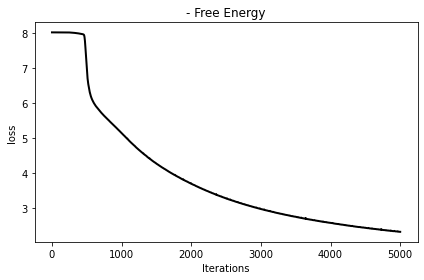

In [44]:
from importlib import reload
from utils_process import plot_rpgpfa_summary, plot_loss
import utils_process
utils_process = reload(utils_process)

plot_loss(rpm, offset=0)


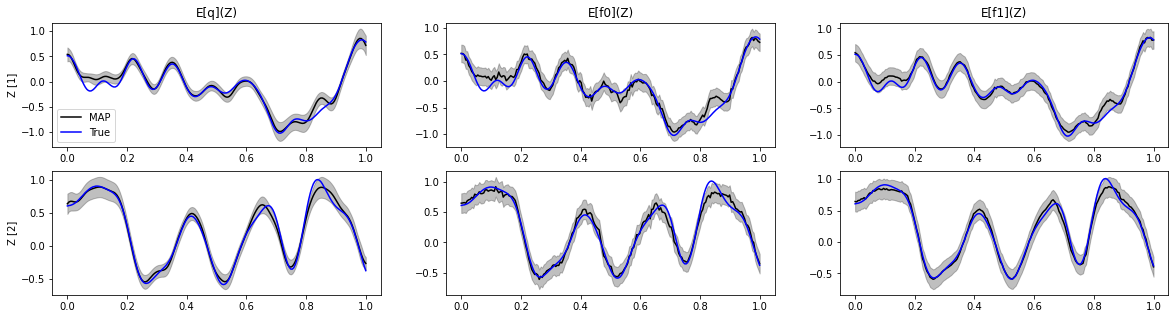

In [50]:

nn = 0
##%%
latent_true = main_trajectory[:num_observation]

fig = utils_process.plot_rpgpfa_summary(
    rpm=rpm,
    plot_id_factors=[0, 1],
    plot_id_observations=[nn],
    plot_variational=True,
    plot_regressed=True,
    plot_variance=True,
    plot_true=True,
    latent_true=latent_true,
    plot_type='linear',
)


fig.set_figwidth(20)
fig.set_figheight(5)

In [49]:
import save_load
save_load = reload(save_load)
save_load.rpm_save(
    model=rpm,
    filename= './latent_video3.pickle',
    device= "cpu",
    true_latent=latent_true,
    observations=observations,
)

In [14]:
save_load = reload(save_load)
loaded_rpm, loaded_observations, loaded_latent = save_load.rpm_load(
    model_name= './latent_video.pickle',
    device= "cpu"
)

RPM on GPU Observations on cpu


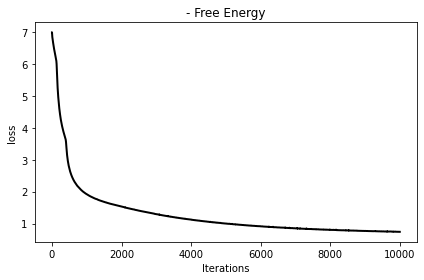

In [15]:
plot_loss(loaded_rpm, offset=0)

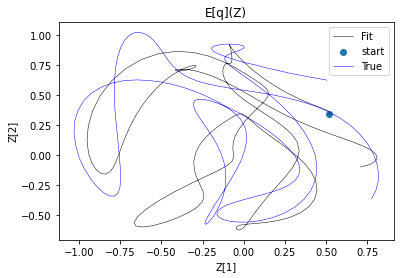

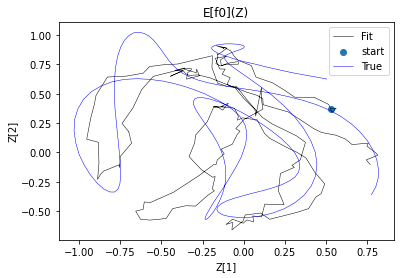

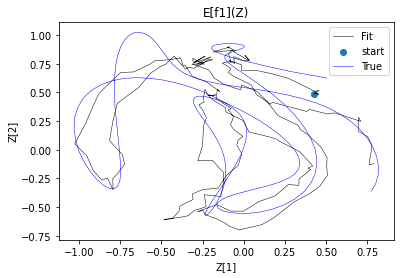

In [18]:
utils_process.plot_rpgpfa_summary(
    rpm=loaded_rpm,
    plot_id_factors=[0, 1],
    plot_id_observations=[nn],
    plot_variational=True,
    plot_regressed=True,
    plot_variance=True,
    plot_true=True,
    latent_true=loaded_latent,
    plot_type='2D',
)

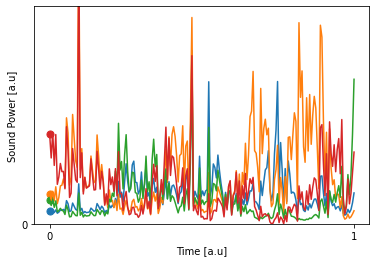

In [120]:

dist = observations[1][nn].detach().clone().cpu().numpy()
dist = dist - dist.min()
dist = dist / dist.max()

plt.figure()
for ii in range(dist.shape[1]):
    tt = np.linspace(0, 1, dist.shape[0])
    plt.plot(tt, dist[:, ii])
    plt.scatter(tt[0], dist[0, ii], s=50)
    
plt.xlabel('Time [a.u]')
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.ylabel('Sound Power [a.u]')
        
plt.ylim([0, 0.75])
plt.savefig("sound_power.pdf")